# From CNNs based to Attention based models: Transformer

The last big step in the evolution of neural networks was the introduction of the Transformer model. This model was introduced in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. in 2017. The Transformer model is based on the self-attention mechanism, which allows it to capture long-range dependencies in the data (what is the differences between this and cnns?). This model has been widely used in natural language processing tasks, such as machine translation, text summarization, and question answering. Recently, it has also been used in computer vision tasks, such as image classification and object detection. In this notebook, we will learn how to implement a simple Transformer model using PyTorch.


## Getting the data and training methods from the previous notebooks

In [144]:
# Let's start by importing torch (you might need to pip install if you haven't already)
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Get the MNIST dataset
# Set up the data preprocessing and loading:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)  # transform the data to torch tensor and normalize
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Now let's split the training set into a training and validation set
generator = torch.Generator().manual_seed(42)  # just a random generator
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000], generator=generator)

print(
    "We loaded {} training, {} validation, and {} testing samples".format(
        len(train_dataset), len(val_dataset), len(test_dataset)
    )
)

# Set up the data loaders (they are iterable objects that return the data in batches)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

We loaded 50000 training, 10000 validation, and 10000 testing samples


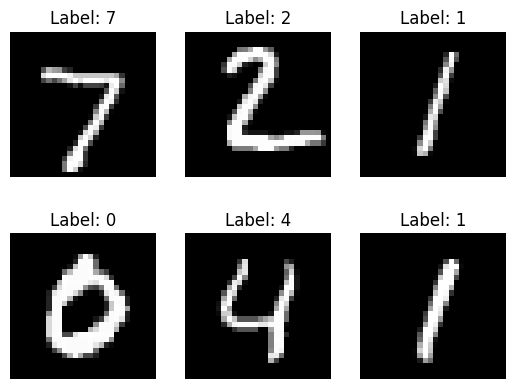

In [2]:
# Visualize some of the data
import matplotlib.pyplot as plt
import numpy as np

examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)
images = images.numpy()  # convert images to numpy for display
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.axis("off")
    plt.title("Label: {}".format(labels[i]))

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # if you are using pc
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")  # if you are using mac

# --- Sanity check --- #
#  verify you are using a gpy based architecture (not mandatory, but makes things faster)
x = torch.ones(1, device=device)
print(x)
del x
# --------------------- #

tensor([1.], device='mps:0')


In [4]:
# Let's use the same trainig method we defined in lecture 7 (with some minnor modifications)
import torch.optim as optim
import numpy as np
from tqdm import tqdm, trange
import torch.nn as nn

np.random.seed(0)
torch.manual_seed(0)


def train_model(model=None, train_loader=None, val_loader=None, log_folder=None):
    num_epochs = 6
    learning_rate = 0.01
    writer = SummaryWriter(log_folder)  # create a tensorboard writer to log the training process
    criterion = nn.CrossEntropyLoss()  # define the loss function as the cross entropy loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.to(device)  # move the model to the device

    for epoch in range(num_epochs):
        model.train()  # set the model to training mode
        for batch_idx, (images, labels) in tqdm(enumerate(train_loader)):
            images, labels = images.to(device), labels.to(device)  # move the data to the device
            optimizer.zero_grad()  # zero the gradients
            output = model(images)  # forward pass
            loss = criterion(output, labels)  # compute the loss
            loss.backward()  # backward pass
            optimizer.step()  # update the weights
            if batch_idx % 100 == 0:
                writer.add_scalar("training loss", loss.item(), epoch * len(train_loader) + batch_idx)
    return model

In [ ]:
# --- Sanity Check --- #
# Verify our training method works with our CNN from lecture 7


# Define the model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.reluconv1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.reluconv2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 16)
        self.relufc1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.reluconv1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.reluconv2(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, 7 * 7 * 64)
        x = self.relufc1(self.fc1(x))
        x = self.logsoftmax(self.fc2(x))
        return x


from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
cnnmodel = CNNNet()
cnnmodel = train_model(
    model=cnnmodel,
    train_loader=train_loader,
    val_loader=val_loader,
    log_folder="torchlogs/cnnnet",
)
# --------------------- #

## Defining the ViT model
We will follow closely 
https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c


In [6]:
class MyViT(nn.Module):
    def __init__(self):
        # Super constructor
        super(MyViT, self).__init__()

    def forward(self, images):
        pass

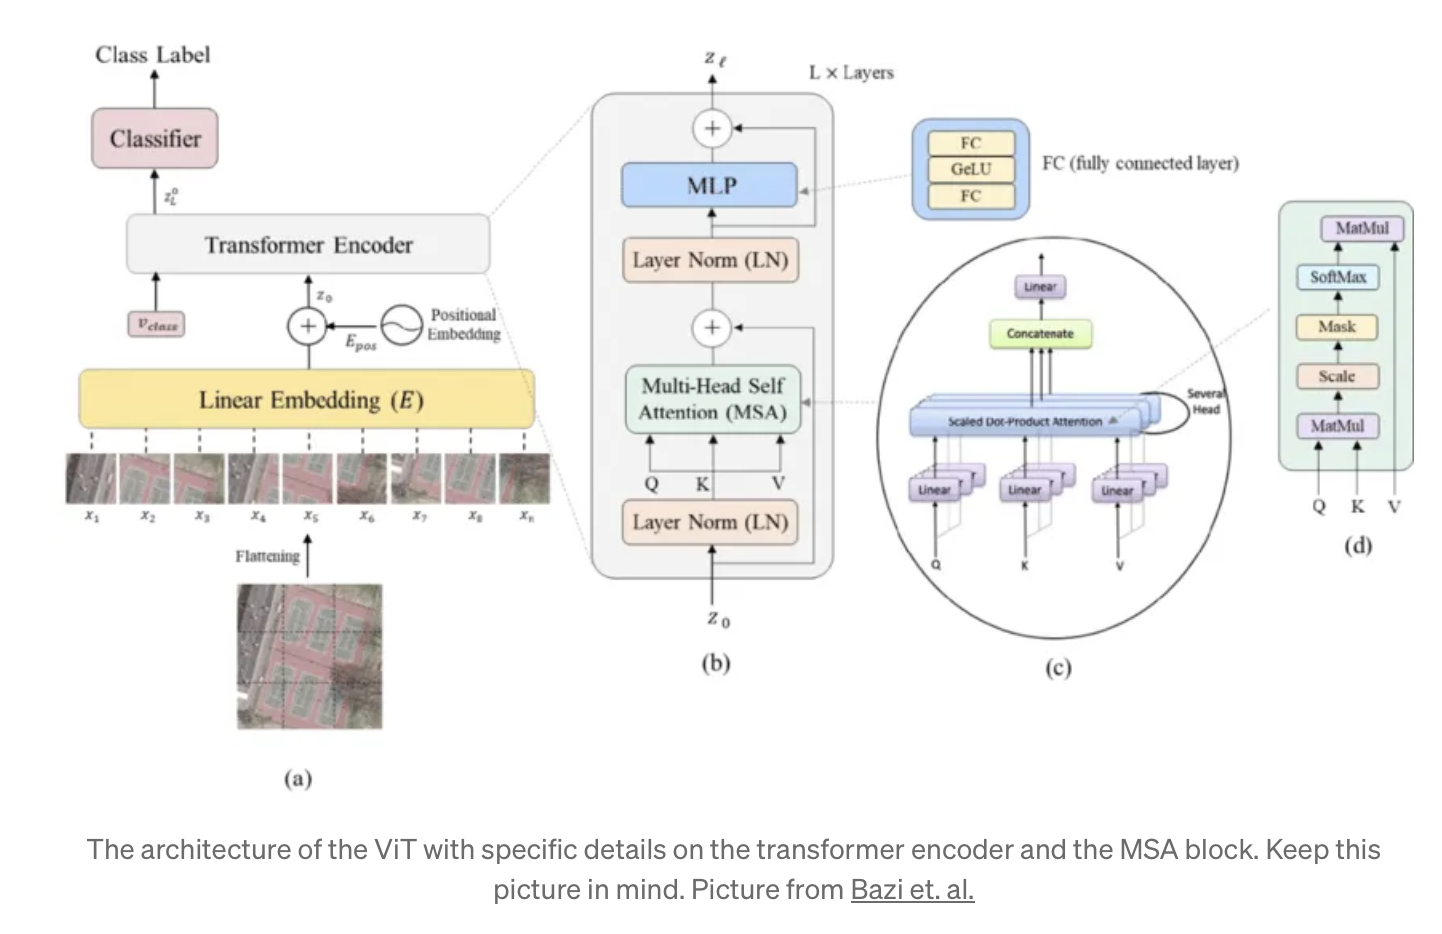

## Step 1: Patchifying the image and linear mapping
(N, 1, 28, 28) -> (N, num_patches, patch_dim) (here patch_dim = 4x4 = 16, and num_patches = 7x7 = 49)
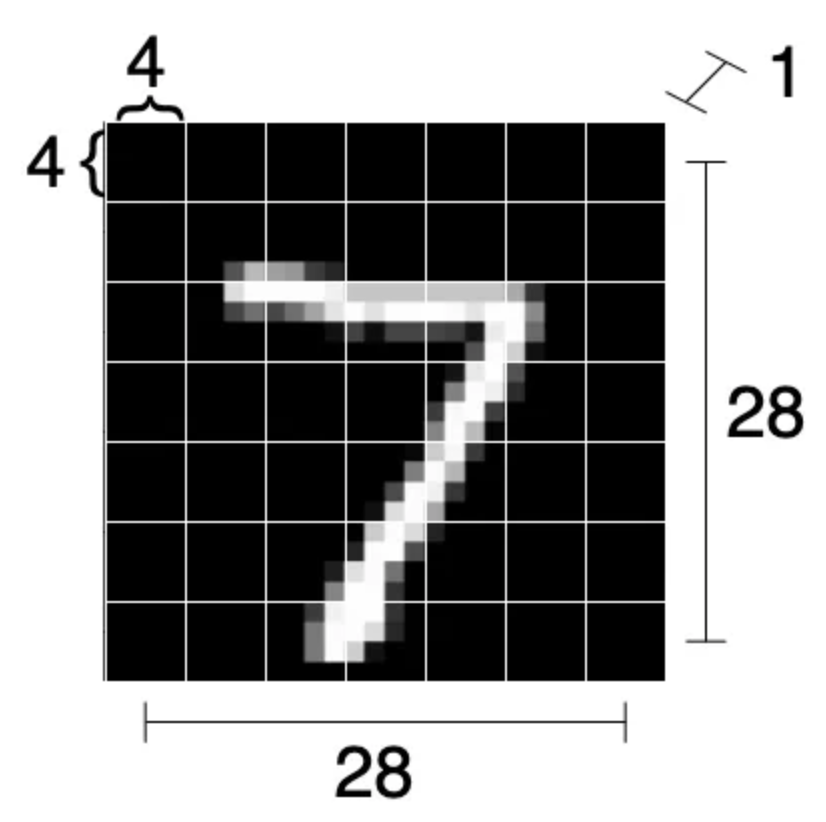

In [7]:
def patchify(images, n_patches_per_side):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"
    patches = torch.zeros(n, n_patches_per_side**2, h * w * c // n_patches_per_side**2)
    patch_size = h // n_patches_per_side

    # ------------------------------------- #
    # Exercise 1: Implement the patchify method
    # ------------------------------------- #
    for idx, image in enumerate(images):
        for i in range(n_patches_per_side):
            for j in range(n_patches_per_side):
                patch = #TODO
                patches[idx, i * n_patches_per_side + j] = patch.flatten()
    return patches

In [8]:
# ---- Sanity check ---- #
# Transform a batch of images to patches
images, _ = next(iter(train_loader))
patches = patchify(images, 7)
print(patches.shape)
# ---------------------- #

torch.Size([256, 49, 16])


In [9]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches  # Number of patches per side

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        return patches

Now we will add the linear embedding layer to map the patches to the embedding dimension.

In [10]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_d  # Hidden dimension

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    def forward(self, images):
        patches = patchify(images, self.n_patches)  # (N, 1, h, w) -> (N, n_p**2, p_size**2)
        tokens = self.linear_mapper(patches)  # (N, n_p**2, p_size**2) -> (N, n_p**2, hidden_d)
        return tokens

## Step 2: Adding the classification token
If you look closely at the architecture picture, you will notice that also a “v_class” token is passed to the Transformer Encoder. What’s this? Simply put, this is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block (later on). When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.
This is a cool concept of transformers! If we wanted to do another downstream task, we would just need to add another special token for the other downstream task (for example, classifying a digit as higher than 5 or lower) and a classifier that takes as input this new token. Clever, right? We can now add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

In [11]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_d  # Hidden dimension

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.randn(1, self.hidden_d))

    def forward(self, images):
        patches = patchify(images, self.n_patches)  # (N, 1, h, w)->(N, n_p**2, p_size**2)
        tokens = self.linear_mapper(patches)  # (N, n_p**2, p_size**2) -> (N, n_p**2, hidden_d)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        return tokens

In [12]:
# ---- Sanity check ---- #
# Current model
model = MyViT(chw=(1, 28, 28), n_patches=7, hidden_d=8)  # Init the model (what we have so far)
x = torch.randn(7, 1, 28, 28)  # A random input batch of images
output = model(x)  # Forward pass (what should be the output size?)
print(output.shape)  # Verify the output tensor for this example makes sense.
# Let's see the class token we just added for this batch
print(output[:, 0, :])
# ---------------------- #

torch.Size([7, 50, 8])
tensor([[ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984],
        [ 0.9301,  0.4460, -0.1796,  0.8418, -1.2685,  2.2854,  0.1731, -1.9984]],
       grad_fn=<SliceBackward0>)


This is what we have so far: 
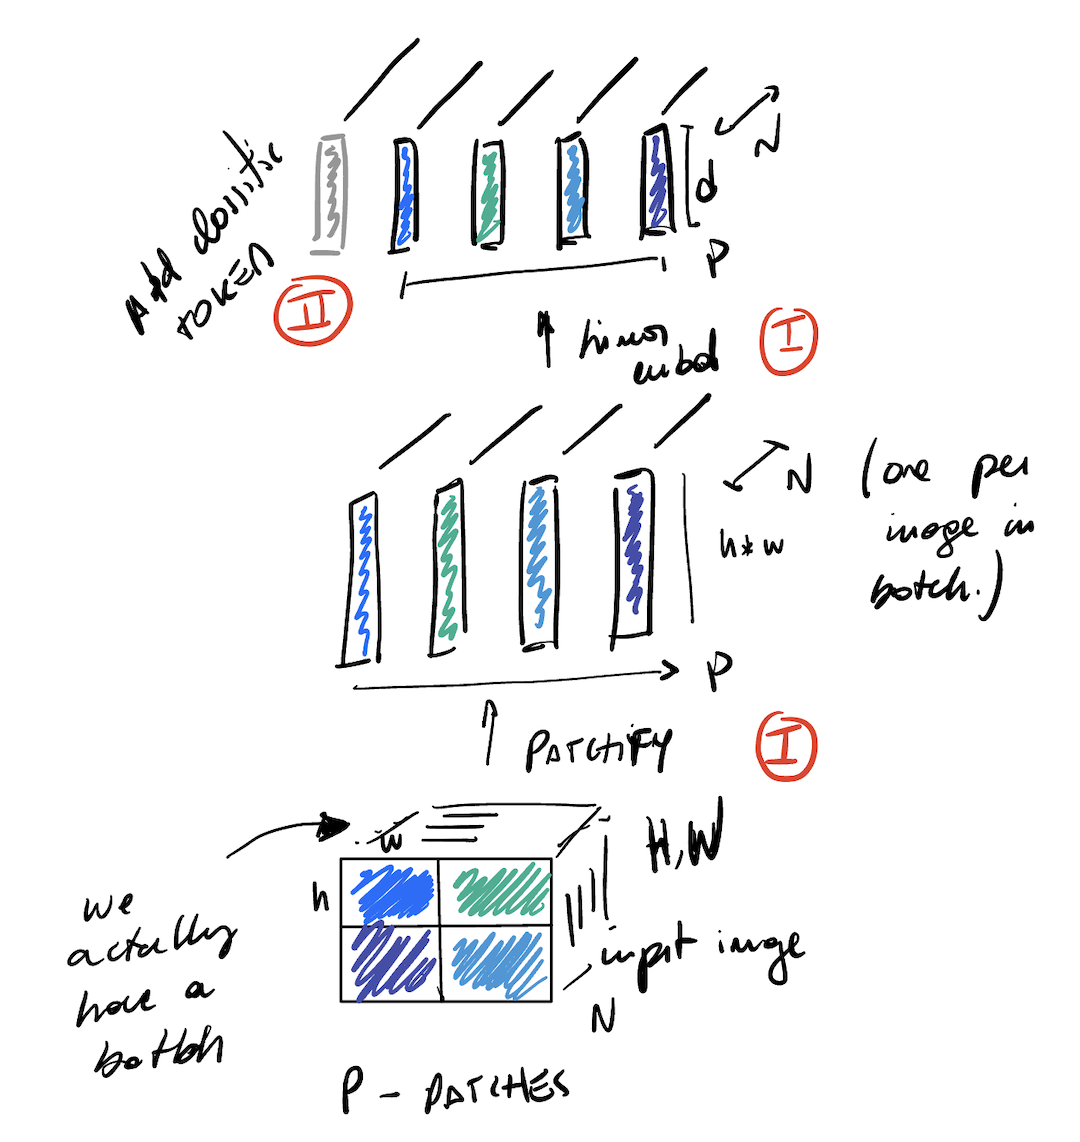

## Step 3: Adding the positional encoding 
As anticipated, positional encoding allows the model to understand where each patch would be placed in the original image. While it is theoretically possible to learn such positional embeddings, previous work by Vaswani et. al. [reference] suggests that we can just add sines and cosines waves.
In particular, positional encoding adds high-frequency values to the first dimensions and low-frequency values to the latter dimensions.
In each sequence, for token i we add to its j-th coordinate the following 
$$PE_{(i, j)} = \sin(i / 10000^{j / d_{model}}) \ \ \ : \ \ j = \dot{2}$$ 
$$PE_{(i, j)} = \cos(i / 10000^{(j-1) / d_{model}}) \ \ \ : \ \ j = \dot{2}+1$$ 

This is a way to add positional information to the tokens. The intuition is that the model will learn to attend to the right tokens in the sequence, and the positional encoding will help it understand where each token is placed in the original image. 
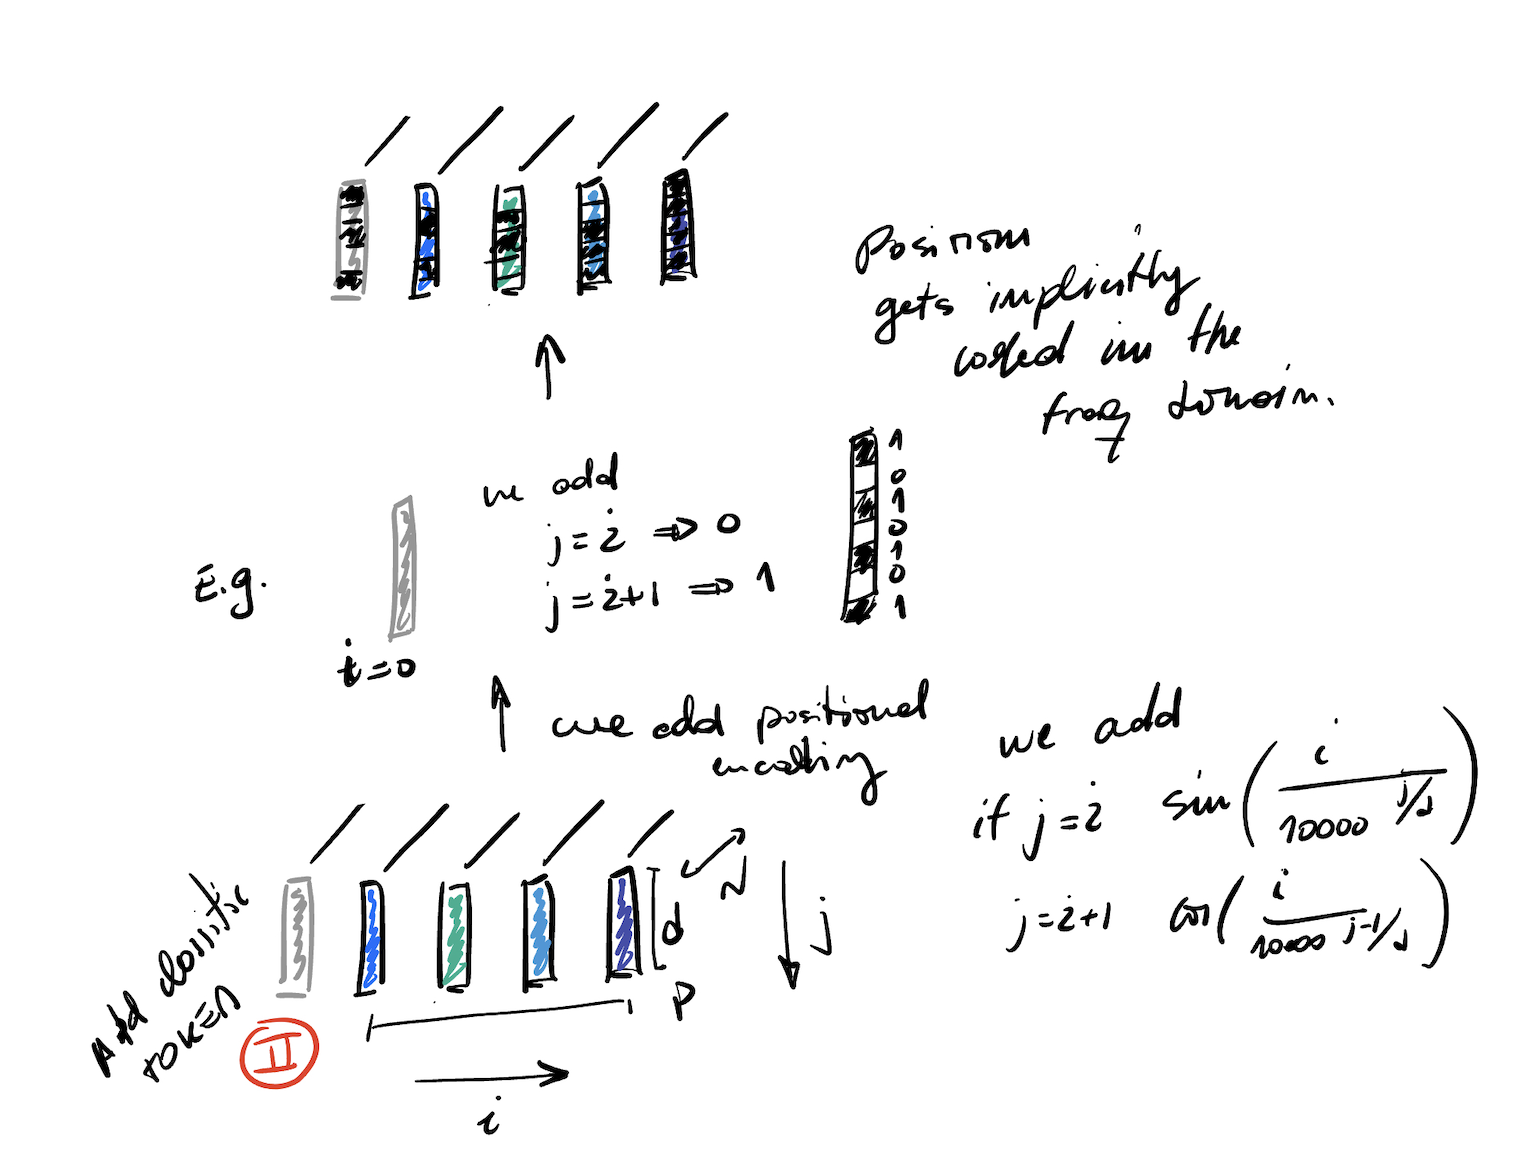

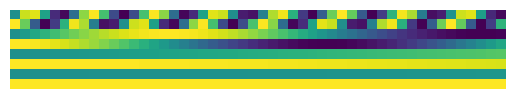

In [13]:
# ------------------------------------- #
# Exercise 2: Implement the positional embeddings
# ------------------------------------- #
def get_positional_embeddings(sequence_length, d):
    #TODO
# ------------------------------------- #

# ---- Sanity check ---- #
plt.imshow(get_positional_embeddings(50, 8).T)
plt.axis("off")
plt.show()

In [14]:
# Now let's add this to the model
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_d  # Hidden dimension

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.randn(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d).clone().detach())
        self.pos_embed.requires_grad = False  # They are not learnable

    def forward(self, images):
        patches = patchify(images, self.n_patches)  # (N, 1, h, w)->(N, n_p**2, p_size**2)
        tokens = self.linear_mapper(patches)  # (N, n_p**2, p_size**2) -> (N, n_p**2, hidden_d)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
        out = tokens + pos_embed
        return out

We define the positional embedding to be a parameter of our model (that we won’t update by setting its requires_grad to False). Note that in the forward method, since tokens have size (N, 50, 8), we have to repeat the (50, 8) positional encoding matrix N times.

In [15]:
# ---- Sanity check ---- #
# Current model
model = MyViT(chw=(1, 28, 28), n_patches=7, hidden_d=8)  # Init the model (what we have so far)
x = torch.randn(7, 1, 28, 28)  # A random input batch of images
output = model(x)  # Forward pass (what should be the output size?)
print(output.shape)  # Verify the output tensor for this example makes sense.
# Let's see the class token we just added for this batch
print(output[:, 0, :])
# ---------------------- #

torch.Size([7, 50, 8])
tensor([[ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320],
        [ 0.0182, -0.5282, -1.3116,  0.2554, -1.2450,  1.1425, -0.0933, -0.7320]],
       grad_fn=<SliceBackward0>)


## Step 4: Defining and adding the transformer block (this is the hard part)
This is possibly the hardest step of all. An encoder block takes as input our current tensor [N, S, D] and outputs a tensor of the same dimensionality.
The first part of the encoder block applies Layer Normalization to our tokens, then a Multi-head Self Attention, and finally adds a residual connection.

### Let's start with the layer normalization

Original ~ 2.0
Normalized mean: 0.0
Original std: 4.0
Normalized std: 1.0


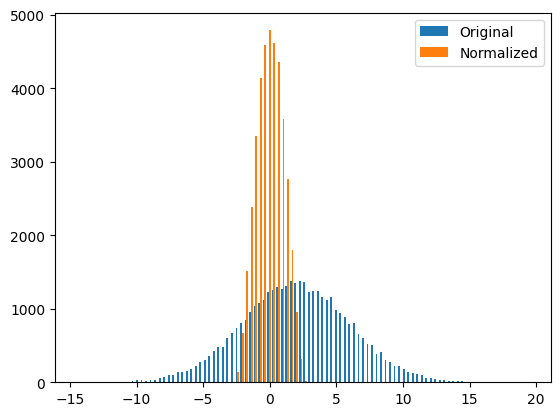

In [70]:
# Toy example, check the behavior of the normalization layer and explain the results
ln = nn.LayerNorm(8, eps=0, elementwise_affine=False, bias=False)  # Layer normalization layer)
x = 4 * torch.randn(100, 50, 8) + 2  # a sample batch

# --------------------------------- #
# Exercise 3:
# --------------------------------- #
# Check the distribution of the embedding values of the toy tensor created above,
# and compare the distribution of the original and the normalized tensor,
# compute and compare the mean and standard deviation of the two distributions.
# Let's check the distribution of values of the "token embeddings" in the batch
# TODO
# --------------------------------- #

### Multi-head self attention
Now we will implement the multi-head self attention. This is the most important part of the transformer model. The multi-head self attention allows the model to capture long-range dependencies in the data by attending to different parts of the input sequence. 
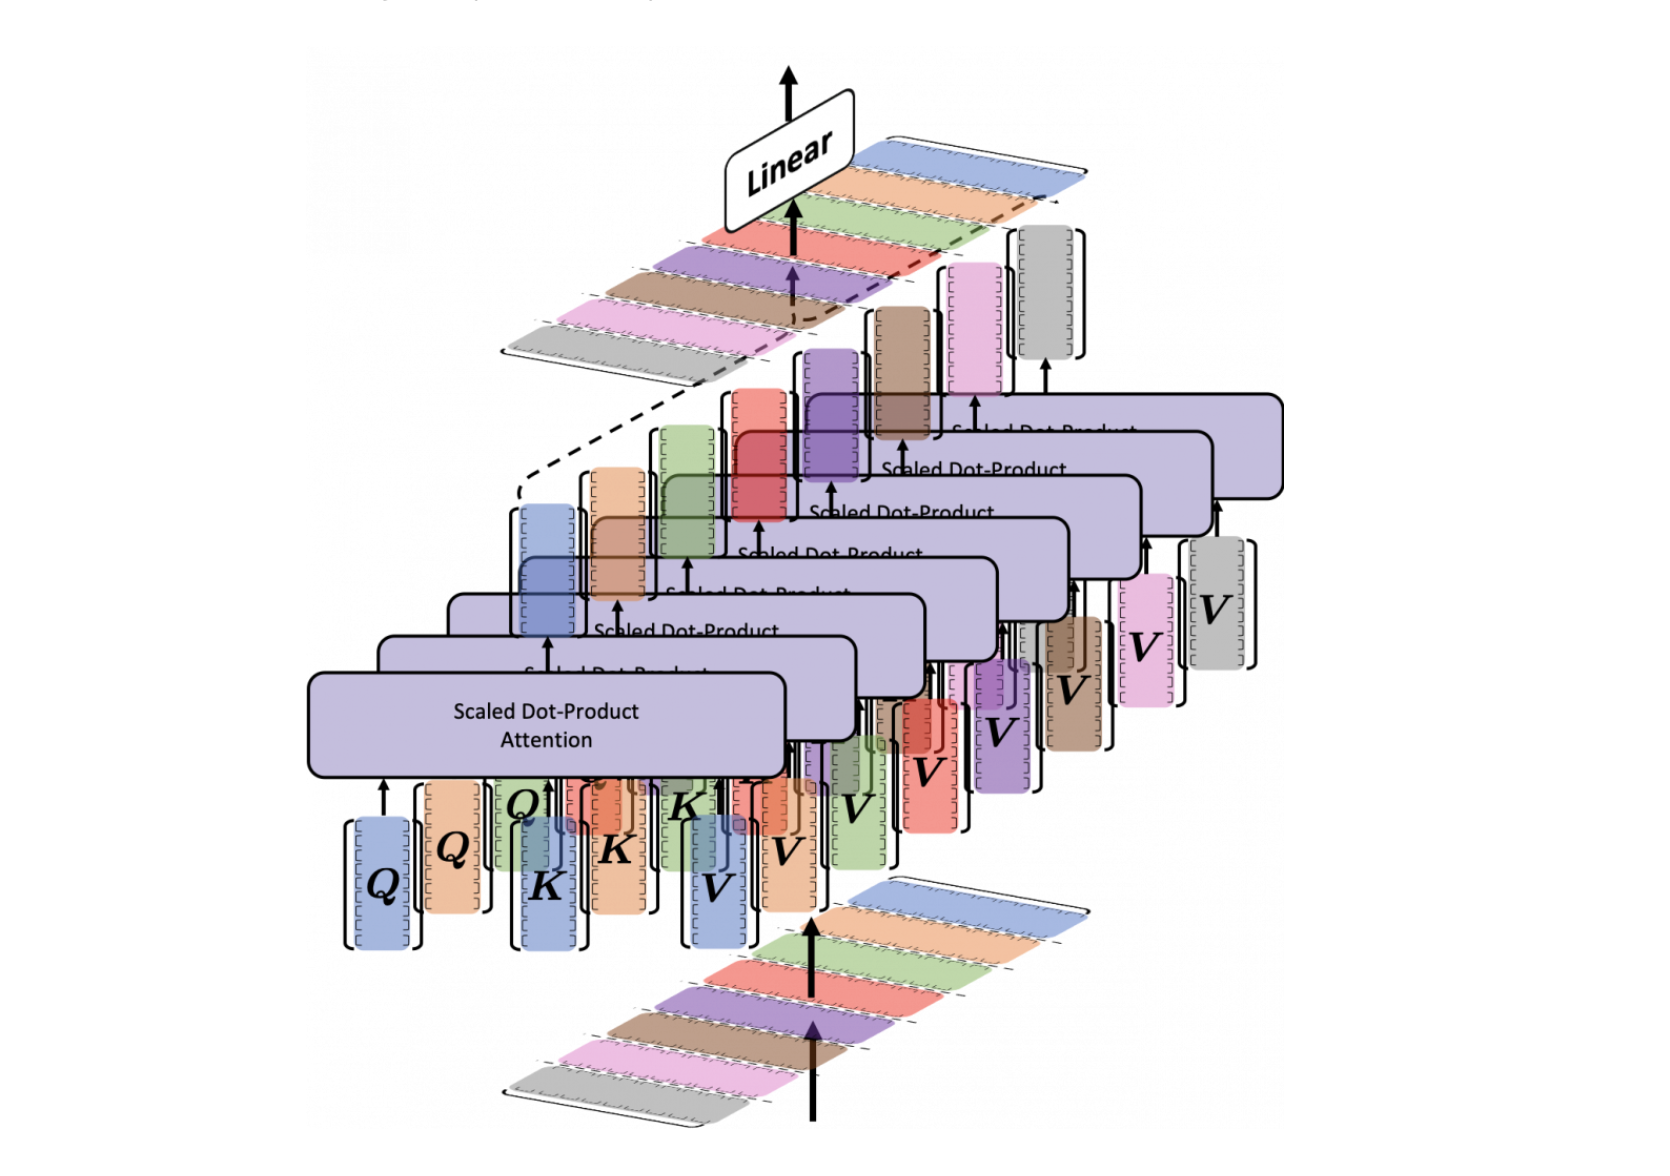

Simply put: we want, for a single image, each patch to get updated based on some similarity measure with the other patches. We do so by linearly mapping each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: q, k, and v (query, key, value).

Then, for a single patch, we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimensionality of these vectors (sqrt(8)), softmax these so-called attention cues, and finally multiply each attention cue with the v vectors associated with the different k vectors and sum all up.

In this way, each patch assumes a new value that is based on its similarity (after the linear mapping to q, k, and v) with other patches. This whole procedure, however, is carried out H times on H sub-vectors of our current 8-dimensional patches, where H is the number of Heads.

Once all results are obtained, they are concatenated together. Finally, the result is passed through a linear layer. The intuitive idea behind attention is that it allows modeling the relationship between the inputs. What makes a ‘0’ a zero are not the individual pixel values, but how they relate to each other.

Since quite some computations are carried out, it is worth creating a new class for MSA:

In [80]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

Notice that, for each head, we create distinct Q, K, and V mapping functions (square matrices of size 4x4 in our example).

Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

Also notice that using loops is not the most efficient way to compute the multi-head self-attention, but it makes the code much clearer for learning.

### Excersie (bonus): 
- Compare the size of the attention map with the size of the learned linear layers for Q, V, and K. 
- What are the advantajes of using the multi-head self attention? Compare the matrices sizes with and without multi-head
- What are the advantajes learning this weights W instead of trying to learn the attention? 
(Sol: A is x dependant, what about number of parameters?)

### Adding the residual connection 
(We discussed this in the previous lecture).

In [81]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

#### With this self-attention mechanism, the class token (first token of each of the N sequences) now has information regarding all other tokens!

In [85]:
# ---- Sanity Check ---- #
model = MyViTBlock(hidden_d=8, n_heads=2)

x = torch.randn(7, 50, 8)  # Dummy sequences
print(f"Model output size {model(x).shape}")  # torch.Size([7, 50, 8])
# ---------------------- #

Model output size torch.Size([7, 50, 8])


If we recall our architecture (see figure), now we just need to add a normalization, fully connected and residual connection. 
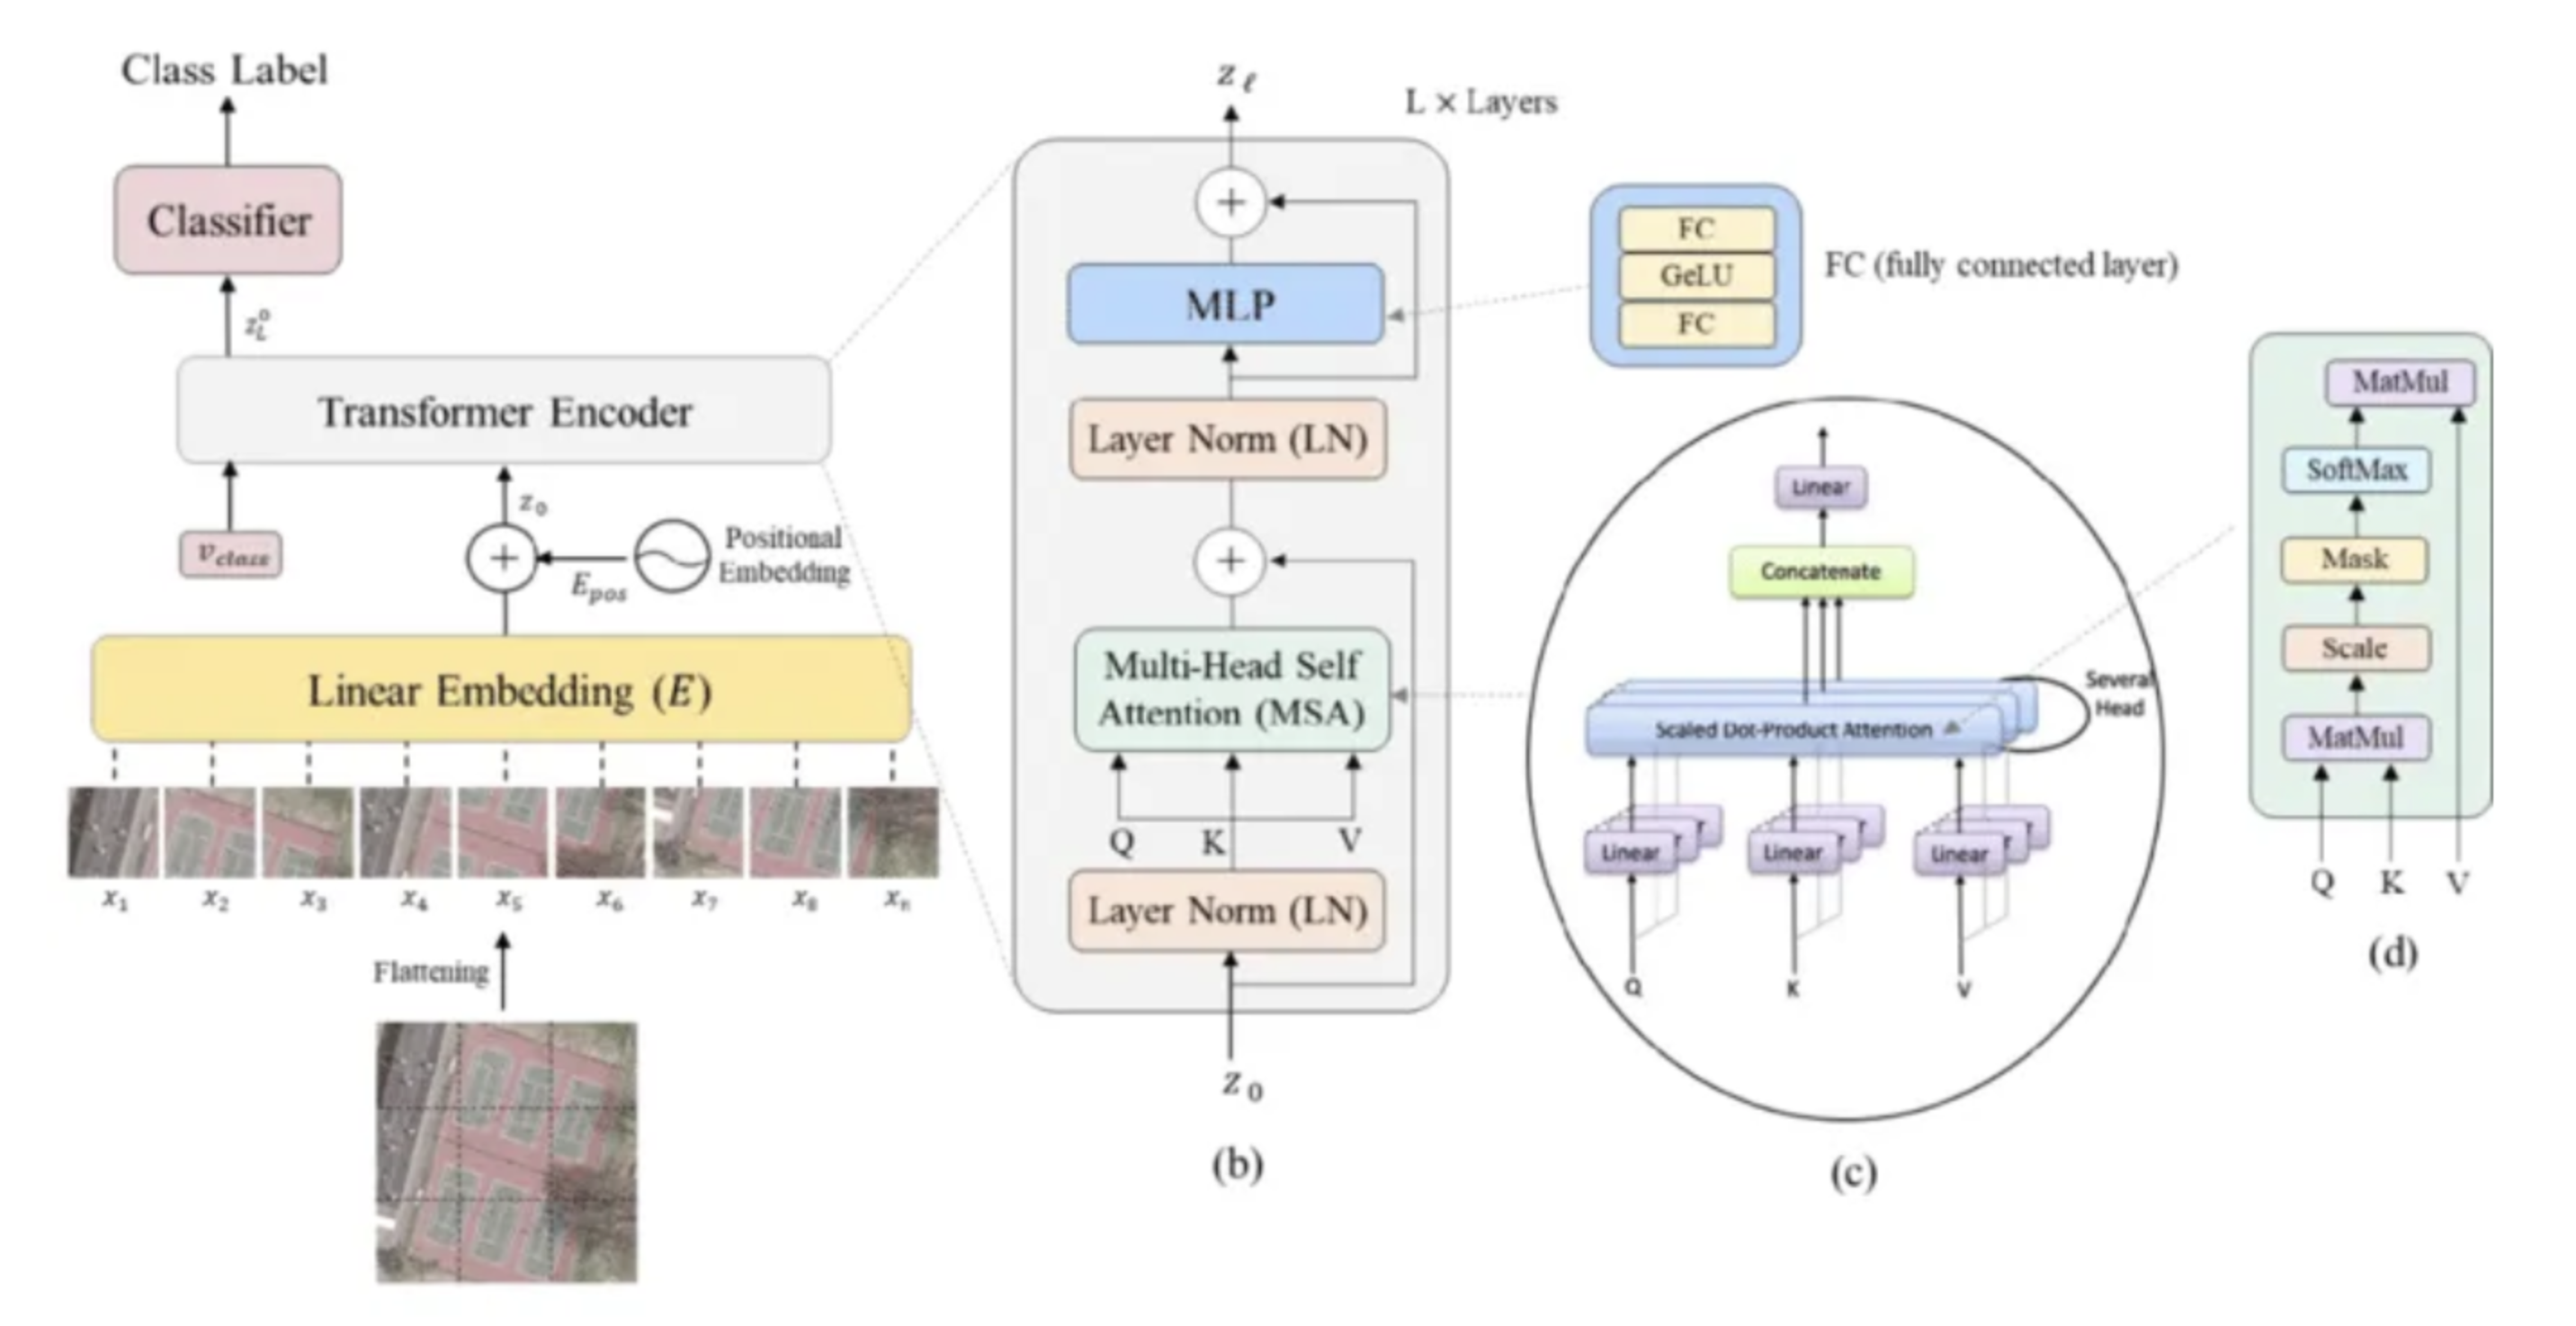

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d), nn.GELU(), nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [87]:
# ---- Sanity Check ---- #
# Again, this block should output a tensor of the same size as the input
model = MyViTBlock(hidden_d=8, n_heads=2)

x = torch.randn(7, 50, 8)  # Dummy sequences
print(f"Model input tensor {x.shape}")  # torch.Size([7, 50, 8])
print(f"Model output tensor {model(x).shape}")  # torch.Size([7, 50, 8])
# ---------------------- #

Model input tensor torch.Size([7, 50, 8])
Model output tensor torch.Size([7, 50, 8])


Now that the encoder block is ready, we just need to insert it in our bigger ViT model which is responsible for patchifying before the transformer blocks, and carrying out the classification after.

We could have an arbitrary number of transformer blocks. In this example, to keep it simple, I will use only 2. We also add a parameter to know how many heads does each encoder block will use.

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8, n_heads=2, n_blocks=2, oud_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_d  # Hidden dimension
        self.n_heads = n_heads  # number of heads in the attention mechanism
        self.n_blocks = n_blocks  # number of transformer blocks
        self.oud_d = oud_d  # dim of the output layer (in this case 10 for the 10 classes)

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.randn(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d).clone().detach())
        self.pos_embed.requires_grad = False  # They are not learnable

        # 4) Trasformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        patches = patchify(images, self.n_patches)  # (N, 1, h, w)->(N, n_p**2, p_size**2)
        tokens = self.linear_mapper(patches)  # (N, n_p**2, p_size**2) -> (N, n_p**2, hidden_d)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
        out = tokens + pos_embed
        # Pass through the transformer blocks
        for block in self.blocks:
            out = block(out)

        return out

In [89]:
# ---- Sanity Check ---- #
model = MyViT()

x = torch.randn(16, 1, 28, 28)  # Dummy sequences of images (16 images)
print(f"Model input tensor {x.shape}")  # [n,c,h,w]
print(f"Model output tensor {model(x).shape}")  # [n, num_patches**2 + 1, hidden_d]
# ---------------------- #

Model input tensor torch.Size([16, 1, 28, 28])
Model output tensor torch.Size([16, 50, 8])


### Step 5: Adding the final classification layer

Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.

Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.


In [130]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8, n_heads=2, n_blocks=2, oud_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_d  # Hidden dimension
        self.n_heads = n_heads  # number of heads in the attention mechanism
        self.n_blocks = n_blocks  # number of transformer blocks
        self.oud_d = oud_d  # dim of the output layer (in this case 10 for the 10 classes)

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.randn(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d).clone().detach())
        self.pos_embed.requires_grad = False  # They are not learnable

        # 4) Trasformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Output layer
        self.mlp = nn.Sequential(nn.Linear(hidden_d, oud_d), nn.Softmax(dim=-1))

    def forward(self, images):
        patches = patchify(images, self.n_patches).to(device)
        tokens = self.linear_mapper(patches)  # (N, n_p**2, p_size**2) -> (N, n_p**2, hidden_d)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
        tokens = tokens + pos_embed
        # Pass through the transformer blocks
        for block in self.blocks:
            tokens = block(tokens)
        # Classification layer using the first token
        token0 = tokens[:, 0, :]
        predicted_scores = self.mlp(token0)
        return predicted_scores

In [131]:
# ---- Sanity Check ---- #
model = MyViT().to(device)

x = torch.randn(16, 1, 28, 28)  # Dummy sequences of images (16 images)
print(f"Model input tensor {x.shape}")  # [n,c,h,w]
print(f"Model output tensor {model(x).shape}")  # [n, 10]
# ---------------------- #

Model input tensor torch.Size([16, 1, 28, 28])
Model output tensor torch.Size([16, 10])


## Now let's train and compare : ) 


In [151]:
def train_model(model=None, train_loader=None, val_loader=None, log_folder=None):
    num_epochs = 6
    learning_rate = 0.005
    writer = SummaryWriter(log_folder)  # create a tensorboard writer to log the training process
    criterion = nn.CrossEntropyLoss()  # define the loss function as the cross entropy loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)  # move the model to the device

    for epoch in range(num_epochs):
        model.train()  # set the model to training mode
        for batch_idx, (images, labels) in tqdm(enumerate(train_loader)):
            images, labels = images.to(device), labels.to(device)  # move the data to the device
            optimizer.zero_grad()  # zero the gradients
            output = model(images)  # forward pass
            loss = criterion(output, labels)  # compute the loss
            loss.backward()  # backward pass
            optimizer.step()  # update the weights
            if batch_idx % 50 == 0:
                writer.add_scalar("training loss", loss.item(), epoch * len(train_loader) + batch_idx)
    return model

In [153]:
# Let's train our CNN for baseline
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
cnnmodel = CNNNet()
cnnmodel = train_model(
    model=cnnmodel,
    train_loader=train_loader,
    val_loader=val_loader,
    log_folder="torchlogs/cnnnet",
)

196it [00:08, 24.02it/s]
196it [00:08, 24.05it/s]
196it [00:08, 23.83it/s]
196it [00:08, 23.68it/s]
196it [00:08, 23.99it/s]
196it [00:08, 24.01it/s]


In [158]:
# And the ViT model
ViTmodel = MyViT()
ViTmodel = train_model(
    model=ViTmodel,
    train_loader=train_loader,
    val_loader=val_loader,
    log_folder="torchlogs/ViT",
)

0it [00:00, ?it/s]

196it [19:27,  5.96s/it]
196it [19:53,  6.09s/it]
196it [19:26,  5.95s/it]
196it [18:59,  5.82s/it]
196it [19:17,  5.90s/it]
196it [19:26,  5.95s/it]


In [149]:
# --------------------------------- #
# Excercise 4: Compare the performance of the CNN and the ViT model on the test set
# --------------------------------- #
def compute_model_accuracy(dataloader, model):
    # TODO

In [156]:
print("CNN model accuracy: ", compute_model_accuracy(test_loader, cnnmodel))

100%|██████████| 40/40 [00:01<00:00, 25.71it/s]

CNN model accuracy:  0.9816


In [159]:
print("ViT model accuracy: ", compute_model_accuracy(test_loader, ViTmodel))

100%|██████████| 40/40 [02:45<00:00,  4.14s/it]

ViT model accuracy:  0.6363


## Hyperparameter tunning (check other ViT configurations)

In [162]:
# ----------------------------------------- #
# Exercise 5: Modify the ViT model to have 4 patches per side, 1 head, and 2 blocks, 32 hidden dimension. Train the model and compare the performance with the previous ViT model
# ----------------------------------------- #
# TODO
# ----------------------------------------- #

196it [07:44,  2.37s/it]
196it [07:44,  2.37s/it]
196it [07:41,  2.36s/it]
196it [08:10,  2.50s/it]
196it [08:36,  2.63s/it]
196it [07:55,  2.43s/it]


In [163]:
print("ViT model accuracy: ", compute_model_accuracy(test_loader, ViTmodel))

100%|██████████| 40/40 [01:03<00:00,  1.59s/it]

ViT model accuracy:  0.8981
